<a href="https://colab.research.google.com/github/thedarredondo/data-science-fundamentals/blob/main/Unit8/Unit8NotesAK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymc-bart

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.3/499.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.26.3
    Uninstalling pytensor-2.26.3:
      Successfully uninstalled pytensor-2.26.3
  Attempting uninstall: pymc
    Found existing installation: pymc 5.18.2
    Uninstalling pymc-5.18.2:
      Successfully uninstalled pymc-5.18.2


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

# Unit 8: Bayesian Additive Regression Trees (BART)

Bayesian Additive Regression Trees (BART) can be thought of as a fast approximation of Gaussian Processes (GPs). The specific way BART models work has various limitations, quirks, and benefits; we'll dicuss them all in this unit.

We'll learn:
- what a decision tree is
- how BART models work, and their relationshipp to decision trees
- how to implement BART in PyMC
- Partial Dependence Plots (PDP)
- Individual Conditional Expecation plots (ICE)
- variable selection with PyMC BART

Let's get started.

## Theoretical Background: Trees and Forests



### Decision Trees

Decision trees are flow charts, but with several restrictions.

### Random Forests and BART

A randomized decision tree on it's own isn't all that useful--but a whole bunch of decision trees with randomized root nodes, added together, are. Any method that combines the results of multiple randomized decision trees is called a Random Forest (RF). RFs turn out to be pretty accurate, and also one of the most interpretable model types, thanks to being built from decision trees. Increasing the number of trees can make RFs very accurate, and RFs can be exceptionally fast to fit if the number of trees isn't too big.

Why is combining trees so much better? If we ensure that there's a diversity of trees (they aren't all making similar decisions), then each tree is picking up on a different pattern in the data. Combining the results of the trees combines all the patterns each tree picked up, resulting in a model that "knows" about all of the patterns and can make better predictions. This is called ensemble learning, where a bunch of weak learners are combined to result in more accurate predictions.

At least, that's what we hope happens. There's no guranttee that each tree will pick up something unique about the data. Luckily, we can ecourage our trees to find different patterns by using a BART model. Here's how:

In addition to the randomized root nodes of a a basic RF, BART builds its trees in a sort of sequential manner. BART actually starts with all the trees it needs, but then randomly alters each tree based on the other trees. The "based on the other trees" bit ensures that BART is encouraging the growth of different trees. This idea is called boosting.

BART goes further though; it selects each change to one of its trees as part of an MCMC. This ensures that the whole BART model is a sample from some posterior distribution. You can find a slightly more in depth summary of the BART model as described [here](https://www.youtube.com/watch?v=xWhPwHZF4c0).

There's a final step also unique to BART, that the video above doesn't really cover: BART puts reularizing priors on the depth of each decision tree, and on the magnitude of the leaf nodes. The priors over the depth helps ensure that all the trees will be shallow, or that the depth will be much less than the number of data points.
Priors on the leaf nodes ensures that our model only explores near the actual data; the leaf node priors are more traditional regularizing priors.



#### Why all the background on how BART works?

BART is a particularly good example of an algorithm that people dreamed up. It started with something that worked (RFs), and kept adding things that helped either reduce underfitting (boosting) or reduce overfitting (MCMC, priors). The result is a flexible model that can accurately fit data, but that we don't have to spend forever tuning in order to avoid overfitting.

In doing so, they discovered something that approximates a known mathematical object (a BART model with infinite trees is a nowhere differentiable Guassian Process), but that is both much faster an easier to use.

One last time: people invented a good model by considering how to best balance underfitting, overfitting, speed, and interpretability.

## Implementing BART in PyMC

Armed with knowledge of how BART works and why we should use it, let's build a model with it.

We'll also use this exuse to play with a new data set about three species of penguins.

On Notation: I haven't quite been following

### Octupus BART

In [26]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [27]:
import preliz as pz

(Gamma(alpha=1.9, beta=0.0011), <Axes: >)

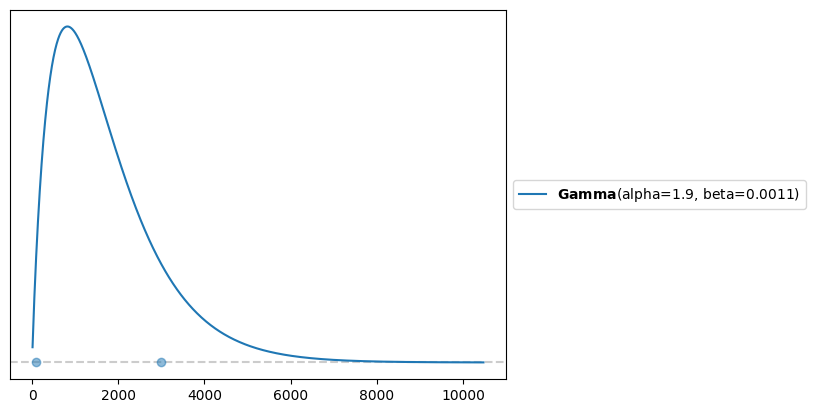

In [36]:
pz.maxent(pz.Gamma(), 100, 3000, 0.85)

<Axes: >

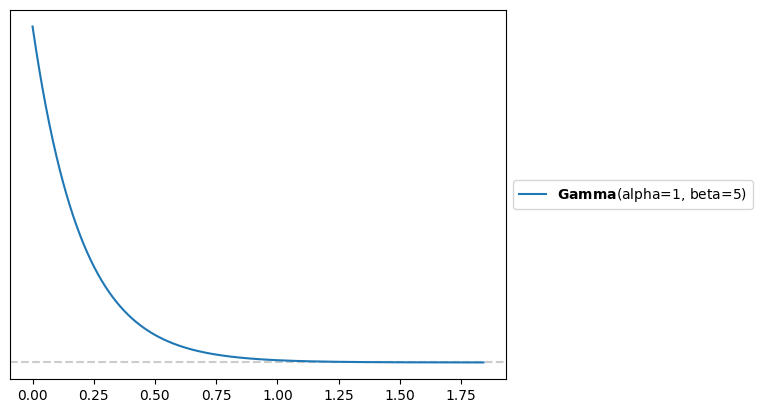

In [47]:
pz.Gamma(1,5).plot_pdf()

In [10]:
octps = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/octopusbeakweight_nlin.csv')

In [12]:
octps.head()

,totWt,upBeak,loBeak,latWall
0,91,78,78,74
1,532,125,120,131
2,537,101,92,138
3,605,85,107,135
4,647,130,101,155


In [84]:
#features = ["upBeak", "loBeak", "latWall"]

X = octps["upBeak"].to_numpy().reshape(-1, 1)
Y = octps["totWt"].to_numpy()

(array([4., 7., 5., 5., 2., 2., 2., 0., 1., 2.]),
 array([  91.,  618., 1145., 1672., 2199., 2726., 3253., 3780., 4307.,
        4834., 5361.]),
 <BarContainer object of 10 artists>)

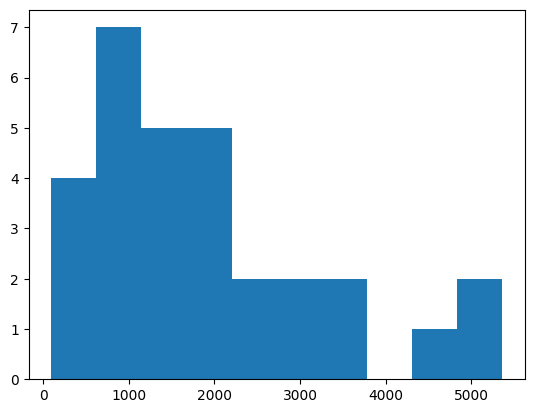

In [20]:
plt.hist(octps.totWt)

In [85]:
with pm.Model() as model_octps:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_octps = pm.sample(compute_convergence_checks=False)

Output()

Output()

Output()

<Axes: xlabel='y'>

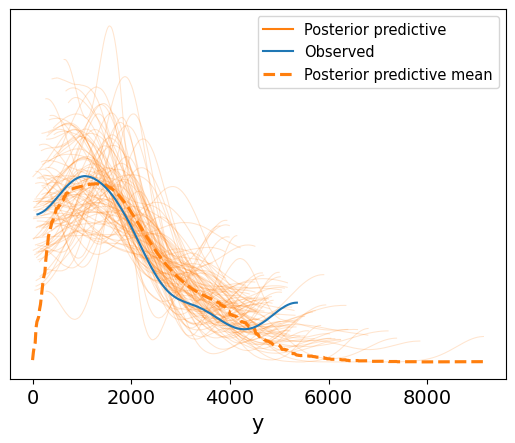

In [86]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_octps,model_octps, extend_inferencedata=True)
az.plot_ppc(idata_octps, num_pp_samples=100, colors=["C1", "C0", "C1"])

In [126]:
posterior_mean = idata_octps.posterior["μ"]

μ_hdi = az.hdi(ary=idata_octps, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_octps, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


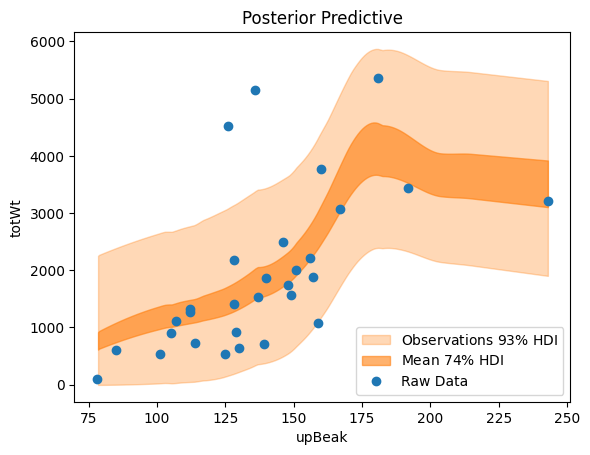

In [128]:
idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Observations $93\%$ HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(octps["upBeak"], octps["totWt"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="upBeak",
    ylabel="totWt",
);

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


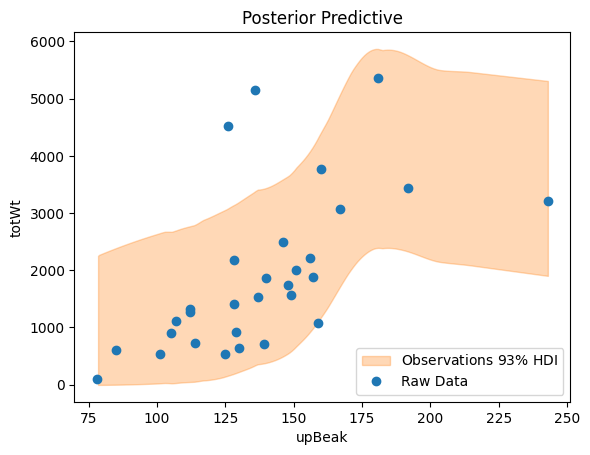

In [93]:
idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Observations $93\%$ HDI"},
)

#az.plot_hdi(
#    x=X[:, 0],
#    hdi_data=np.exp(μ_hdi["μ"].sel(μ_dim_0=0)),
#    ax=ax,
#    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
#)
ax.plot(octps["upBeak"], octps["totWt"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="upBeak",
    ylabel="totWt",
);

### Penguins

In [ ]:
#drop the incomplete rows from the data
penguins = pd.read_csv("https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv").dropna()

#Y is what we want to predict
Y = penguins["body_mass"]

#make a copy of the penguins df to manipulate
pen = penguins

In [ ]:
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [ ]:
#replace the strings in our data set with numbers
#this will allows bart to process them
pen['sex'] = pen['sex'].replace(['male', 'female'],[0, 1])
pen['species'] = pen['species'].replace(['Adelie', 'Chinstrap', 'Gentoo'],[0, 1, 2])

#I combine all my predictor variables into one dataframe
X = pen[["flipper_length", "bill_depth", "bill_length"]]

In [ ]:
pen

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,0,Torgersen,3.91,1.87,18.1,3.750,0,2007
1,0,Torgersen,3.95,1.74,18.6,3.800,1,2007
2,0,Torgersen,4.03,1.80,19.5,3.250,1,2007
4,0,Torgersen,3.67,1.93,19.3,3.450,1,2007
5,0,Torgersen,3.93,2.06,19.0,3.650,0,2007
...,...,...,...,...,...,...,...,...
339,1,Dream,5.58,1.98,20.7,4.000,0,2009
340,1,Dream,4.35,1.81,20.2,3.400,1,2009
341,1,Dream,4.96,1.82,19.3,3.775,0,2009
342,1,Dream,5.08,1.90,21.0,4.100,0,2009


In [ ]:
with pm.Model() as model_pen:
    #priors
    σ = pm.HalfNormal("σ", 1)
    # m is the number of trees
    μ = pmb.BART("μ", X, Y, m=50)

    #likelihood
    y = pm.Normal("y", mu=μ, sigma=σ, observed=Y)

    #run the samples
    idata_pen = pm.sample()

/usr/local/lib/python3.10/dist-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/

Output()

Output()

/usr/local/lib/python3.10/dist-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/

In [ ]:
idata_pen

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_pen,model_pen, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

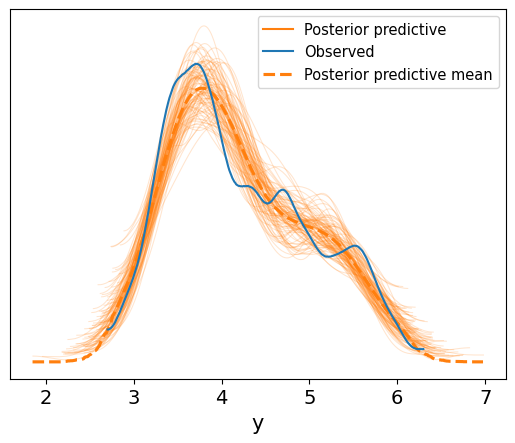

In [ ]:
az.plot_ppc(idata_pen, num_pp_samples=100, colors=["C1", "C0", "C1"])

### Partial Dependence Plots (pdp)

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

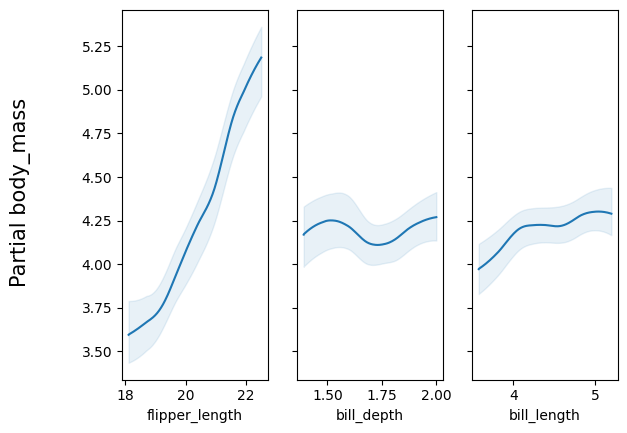

In [ ]:
pmb.plot_pdp(μ, X, Y, grid=(1, 3))

#### Individual Conditional Expectation Plots (ice)

(30, 333, 1)
(30, 333, 1)
(30, 333, 1)


array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

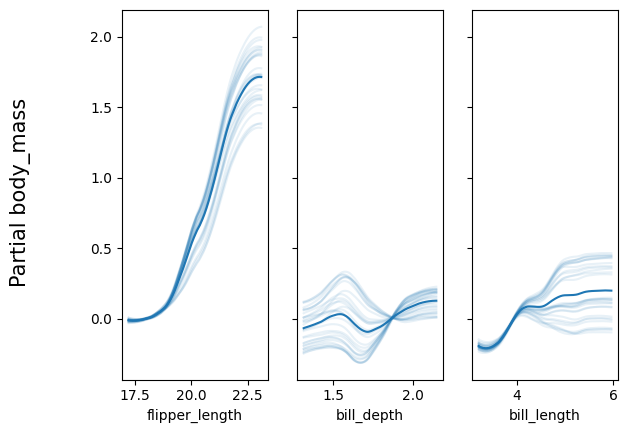

In [ ]:
pmb.plot_ice(μ, X, Y, grid=(1, 3))

#### Variable Importance Plots

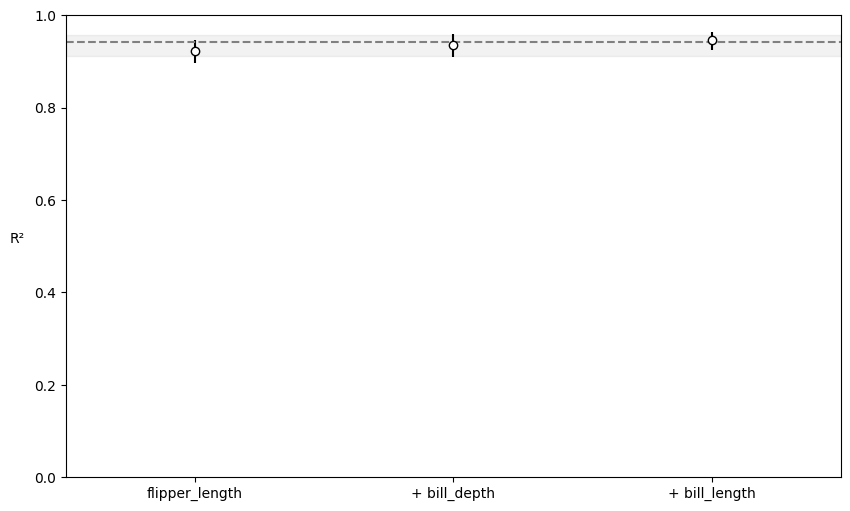

In [ ]:
_, ax = pmb.plot_variable_importance(idata_pen, μ, X, figsize=(10, 6))
#ax[0].set_ylim(0, .6)
#ax[1].set_ylim(0.7, 1)

### Bartian Bikes

In [3]:
bikes = pd.read_csv("https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/bikes.csv").dropna()
features = ["hour", "temperature", "humidity","weekday"]

X = bikes[features]
Y = bikes["rented"]

In [4]:
with pm.Model() as model_bikes:
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(Y), m=50)
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y)
    idata_bikes = pm.sample(compute_convergence_checks=False)

Output()

Output()

In [6]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_bikes,model_bikes, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

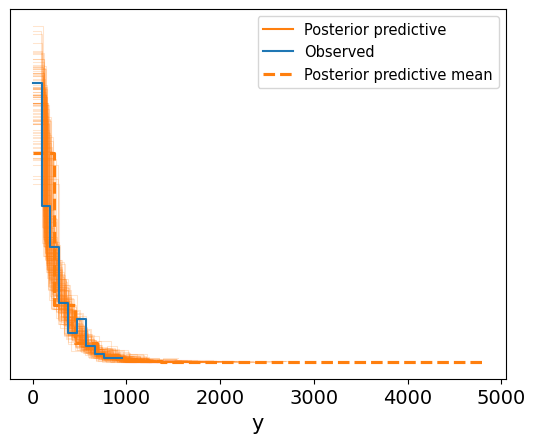

In [7]:
az.plot_ppc(idata_bikes, num_pp_samples=100, colors=["C1", "C0", "C1"])

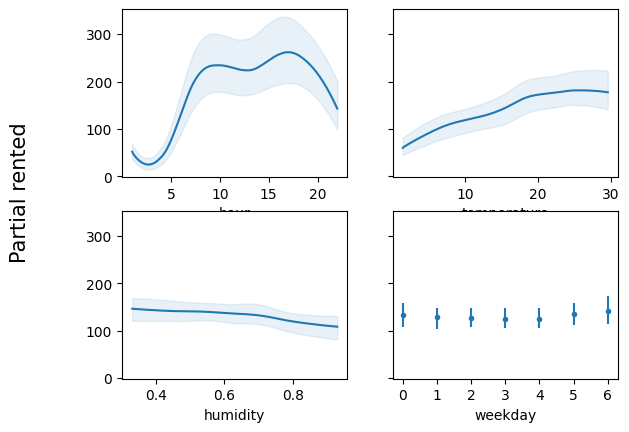

In [8]:
pmb.plot_pdp(μ, X=X, Y=Y, grid=(2, 2), func=np.exp, var_discrete=[3]);

([0, 1, 3, 2], <Axes: ylabel='R²'>)

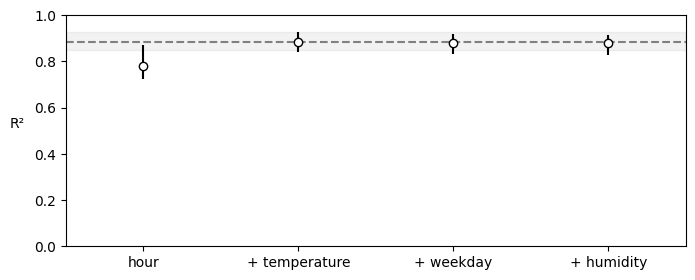

In [9]:
pmb.plot_variable_importance(idata_bikes, μ, X)